In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import sys
from UclaDataLoader import UclaDataLoader
from CedarsDataLoader import CedarsDataLoader
from CombineData import CombineData
from SplitData import SplitData
from TrainModel import TrainModel
from TestModel import TestModel
import viz_utils
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
# ucla files
ddr_path='/opt/genomics/workingdir/arudas/projects/COVID19/ResultPrediction'
ddr_path_freezed = '/opt/genomics/workingdir/jnchiang/projects/COVID_19/models/LabTestProxy/data_freeze'


ucla_labs = os.path.join(ddr_path_freezed,'covid_labs_v2_filtered.csv')
ucla_encounters = os.path.join(ddr_path,'covid_encounters_v2.rpt')
ucla_patients = os.path.join(ddr_path,'covid_patients_v2.rpt')


# Read data #
dataSets = ['ucla']
dataDict = {}

anyInfMarker = True

excludeSupps = False

In [6]:
%%time
dataDict['ucla'] = {}
dataDict['ucla']['data'], dataDict['ucla']['trainIDs'], dataDict['ucla']['testIDs'] =\
    UclaDataLoader(ucla_labs, ucla_encounters, ucla_patients, anyInfMarker=anyInfMarker)

100%|██████████| 17734/17734 [00:06<00:00, 2705.20it/s]


Number of features: 21


100%|██████████| 6067/6067 [00:48<00:00, 125.28it/s]


CPU times: user 2min 11s, sys: 15.3 s, total: 2min 27s
Wall time: 2min 25s


In [7]:
immsuppfile = '/opt/genomics/workingdir/jnchiang/projects/COVID_19/models/LabTestProxy/Immunosuppressed_CSNIDs.csv'
if excludeSupps:
    supps = pd.read_csv(immsuppfile, error_bad_lines=False)['PatientEncounterCSNID'].values
    dataDict['ucla']['data']=dataDict['ucla']['data'].loc[\
                                    ~dataDict['ucla']['data']['PatientEncounterCSNID'].isin(supps)]
    dataDict['ucla']['trainIDs'] = [x for x in dataDict['ucla']['trainIDs'] if x not in supps]
    dataDict['ucla']['testIDs'] = [x for x in dataDict['ucla']['testIDs'] if x not in supps]

In [9]:
print('Pool numbers:')
all_ucla = len(dataDict['ucla']['data'])
train_ucla = len(dataDict['ucla']['trainIDs'])
test_ucla = len(dataDict['ucla']['testIDs'])

print('UCLA - all: %i, train: %i, test: %i' % (all_ucla,train_ucla,test_ucla))


Pool numbers:
UCLA - all: 1455, train: 1455, test: 1306


In [10]:
# Combine data #
allData, trainIDs, testIDs = CombineData(dataDict)

ucla samples: 1455


In [11]:
allData.groupby(by=['positive']).count()[['PatientEncounterCSNID']]

,PatientEncounterCSNID
positive,
0,1273
1,182


In [13]:
# Dropping features, if necessary #
dropCols = ['D-DIMER']#, 'Ferritin', 'Lactate Dehydrogenase', 'C-Reactive Protein']
allData = allData.drop(dropCols, axis=1)

randSt=np.random.RandomState(10)

In [15]:
# Split data #
trainData, valData, testData = SplitData(allData, trainIDs, testIDs, n_val=10, n_test=30, balanced=False,random_state=8)

In [16]:
trainData.shape[0], valData.shape[0], testData.shape[0]

(940, 123, 392)

In [17]:
func = (lambda x,y: (x,y))
func2 = (lambda x,y: (x[0],x[1],y))
print(trainData.isna().sum().combine(valData.isna().sum(), func).combine(testData.isna().sum(), func2))

PatientEncounterCSNID             (0, 0, 0)
Hemoglobin                        (2, 0, 1)
Absolute Lymphocyte Count         (0, 0, 0)
Absolute Neut Count               (0, 0, 0)
PLATELET COUNT, AUTO              (4, 0, 2)
C-Reactive Protein           (338, 43, 136)
Ferritin                     (477, 67, 193)
Absolute Baso Count               (0, 0, 0)
Absolute Eos Count                (0, 0, 0)
Absolute Mono Count               (0, 0, 0)
Lactate Dehydrogenase        (437, 53, 203)
Red Blood Cell Count              (1, 0, 0)
Lymp/Neut                         (0, 0, 0)
Age                               (0, 0, 0)
negative                          (0, 0, 0)
positive                          (0, 0, 0)
Male                              (0, 0, 0)
dtype: object


Experiment: OnlyCBCandDem, train
Selected threshold: 0.24
AUC:
0.999566992453297
PR_AUC:
0.9969076955976252
sensitivity : 1.00 95%CI (1.00, 1.00)
specificity : 0.01 95%CI (0.01, 0.02)
ppv : 0.13 95%CI (0.11, 0.15)
npv : 1.00 95%CI (1.00, 1.00)
fpr : 0.99 95%CI (0.98, 0.99)
tpr : 1.00 95%CI (1.00, 1.00)
......................................................
Experiment: OnlyCBCandDem, val
Selected threshold: 0.24
AUC:
1.0
PR_AUC:
1.0
sensitivity : 1.00 95%CI (1.00, 1.00)
specificity : 0.85 95%CI (0.79, 0.92)
ppv : 0.36 95%CI (0.17, 0.57)
npv : 1.00 95%CI (1.00, 1.00)
fpr : 0.15 95%CI (0.08, 0.21)
tpr : 1.00 95%CI (1.00, 1.00)
......................................................
Experiment: OnlyCBCandDem, test
Selected threshold: 0.24
AUC:
0.7870370370370371
PR_AUC:
0.4991364344015497
sensitivity : 1.00 95%CI (1.00, 1.00)
specificity : 0.01 95%CI (0.00, 0.03)
ppv : 0.14 95%CI (0.11, 0.17)
npv : 1.00 95%CI (1.00, 1.00)
fpr : 0.99 95%CI (0.97, 1.00)
tpr : 1.00 95%CI (1.00, 1.00)
.........

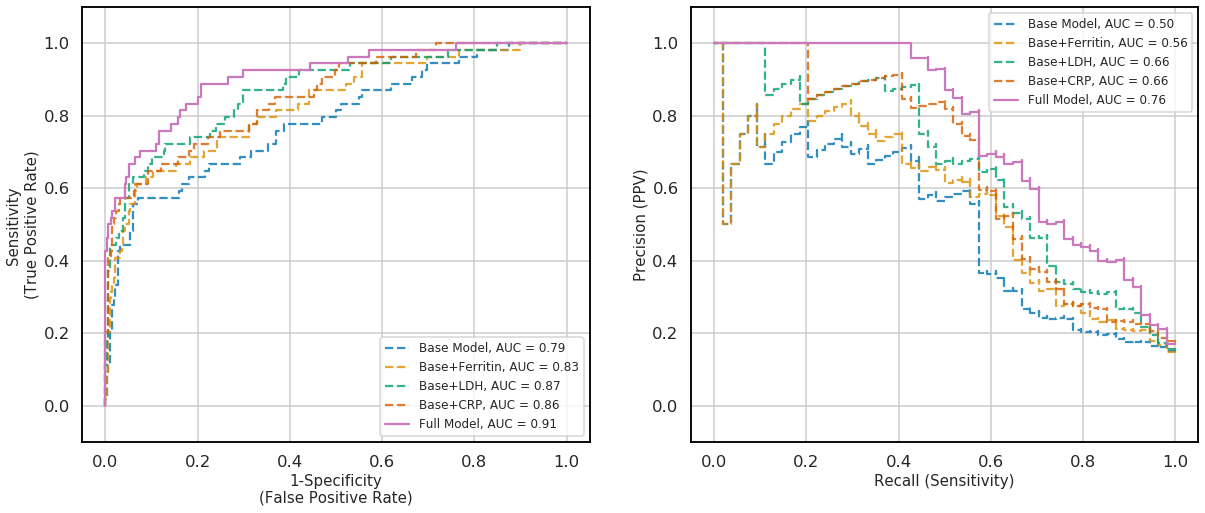

In [18]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid', {'axes.apines.bottom': True,
                           'axes.apines.left': True,
                           'axes.apines.right': False,
                           'axes.apines.top': False,
                           'axes.edgecolor': '.0'})
sns.set_context('talk')
sns.set_palette('colorblind')
label_names = {
    "OnlyCBCandDem": "Base Model",
    "NoFerritin": "Full-Ferritin",
    "NoLDH": "Full-LDH",
    "NoCRP": "Full-CRP",
    "full": "Full Model"
}
label_names2 = {
    "OnlyCBCandDem": "Base Model",
    "BaseFerritin": "Base+Ferritin",
    "BaseLDH": "Base+LDH",
    "BaseCRP": "Base+CRP",
    "full": "Full Model"
}

plotdir='/opt/genomics/Jupyter_Notebook/ARudas/CDM_queries/CDM_Covid19/covid19plots/0908'

experiments={}
expnames=['OnlyCBCandDem'
          , 'NoFerritin'
          , 'NoLDH'
          , 'NoCRP'
          , 'full'
         ]
expnames2=['OnlyCBCandDem'
          , 'BaseFerritin'
          , 'BaseLDH'
          , 'BaseCRP'
          , 'full'
         ]
datasets=[
    'train', 
    'val', 
    'test']

y_vectors = {}

f2, axarr2 = plt.subplots(1, 2, figsize=(20, 8))
axarr2[0].set_ylim((-0.1,1.1))
axarr2[1].set_ylim((-0.1,1.1))

all_results = {}

for exp in expnames2:
    y_vectors[exp]={}
    all_results[exp]={}
    colToDrop = []
    if exp == 'OnlyCBCandDem':
        colToDrop = ['Ferritin', 'Lactate Dehydrogenase', 'C-Reactive Protein']
    if exp == 'NoFerritin':
        colToDrop = ['Ferritin']
    if exp == 'NoLDH':
        colToDrop = ['Lactate Dehydrogenase']
    if exp == 'NoCRP':
        colToDrop = ['C-Reactive Protein']
    if exp == 'BaseFerritin':
        colToDrop = ['Lactate Dehydrogenase', 'C-Reactive Protein']
    if exp == 'BaseLDH':
        colToDrop = ['Ferritin', 'C-Reactive Protein']
    if exp == 'BaseCRP':
        colToDrop = ['Ferritin', 'Lactate Dehydrogenase']
        
    # Train and tune model #
    model = TrainModel(trainData.drop(colToDrop, axis=1), valData.drop(colToDrop, axis=1),\
                       iterations=10, beta=5, minThr=15, maxThr=40, verbose=False)
    
    for dataset in datasets:
        y_vectors[exp][dataset]={}
        
        # Test model #
        if dataset == 'train':
            results = TestModel(model, trainData.drop(colToDrop, axis=1), showReport=False)
        if dataset == 'val':
            results = TestModel(model, valData.drop(colToDrop, axis=1), showReport=False)
        if dataset == 'test':
            results = TestModel(model, testData.drop(colToDrop, axis=1), showReport=False)

        y_test=results['y_test']
        y_prob=results['y_prob']
        y_pred=results['y_pred']
        y_vectors[exp][dataset]['y_test']=y_test
        y_vectors[exp][dataset]['y_prob']=y_prob
        y_vectors[exp][dataset]['y_pred']=y_pred


        # Metrics
        print('Experiment: %s, %s' % (exp, dataset))
        print('Selected threshold: %.2f' % model[2])
        print('AUC:')
        print(results['roc']['auc'])
        print('PR_AUC:')
        print(results['prcurve']['auc'])
        viz_utils.plot_cis(list(y_test.values), np.array(y_prob), threshold_to_use=model[2], plot=False)
        print('......................................................')

        fpr,tpr,thr,auc = results['roc']['fpr'], results['roc']['tpr'], results['roc']['thr'], results['roc']['auc']
        prec, rec, pr_auc = results['prcurve']['precisions'], results['prcurve']['recalls'], results['prcurve']['auc']


        if dataset=='test':
            all_results[exp]=results
            if exp=='full':
                axarr2[0].plot(fpr,tpr, label=label_names2[exp]+', AUC = %.2f' % auc,linestyle='-', alpha=1.0)
                axarr2[1].step(rec,prec, label=label_names2[exp]+', AUC = %.2f' % pr_auc,linestyle='-', alpha=1.0)
            else:
                axarr2[0].plot(fpr,tpr, label=label_names2[exp]+', AUC = %.2f' % auc,linestyle='--', alpha=0.8)
                axarr2[1].step(rec,prec, label=label_names2[exp]+', AUC = %.2f' % pr_auc,linestyle='--', alpha=0.8)
            

axarr2[0].set_xlabel('1-Specificity\n(False Positive Rate)', fontsize=15)
axarr2[0].set_ylabel('Sensitivity \n(True Positive Rate)', fontsize=15)
axarr2[1].set_xlabel('Recall (Sensitivity)', fontsize=15)
axarr2[1].set_ylabel('Precision (PPV)', fontsize=15)
axarr2[0].legend(fontsize=12)
axarr2[1].legend(fontsize=12)

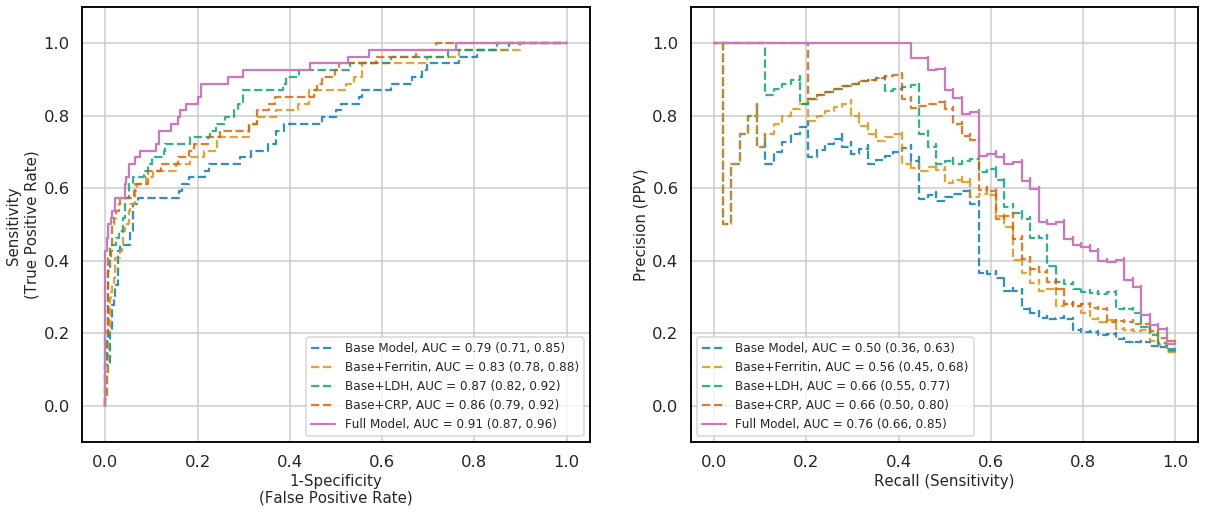

In [19]:
label_names2 = {
    "OnlyCBCandDem": "Base Model",
    "BaseFerritin": "Base+Ferritin",
    "BaseLDH": "Base+LDH",
    "BaseCRP": "Base+CRP",
    "full": "Full Model"
}

aucs = {
    "BaseCRP": (0.79, 0.92),
    "BaseLDH": (0.82, 0.92),
    "BaseFerritin": (0.78, 0.88),
    "OnlyCBCandDem": (0.71, 0.85),
    "full": (0.87, 0.96)
}

prcs = {
    "BaseCRP": (0.50, 0.80),
    "BaseLDH": (0.55, 0.77),
    "BaseFerritin": (0.45, 0.68),
    "OnlyCBCandDem": (0.36, 0.63),
    "full": (0.66, 0.85)
}

f2, axarr2 = plt.subplots(1, 2, figsize=(20, 8))
axarr2[0].set_ylim((-0.1,1.1))
axarr2[1].set_ylim((-0.1,1.1))

for exp in expnames2:
    fpr,tpr,thr,auc = all_results[exp]['roc']['fpr'], all_results[exp]['roc']['tpr'], all_results[exp]['roc']['thr'], all_results[exp]['roc']['auc']
    prec, rec, pr_auc = all_results[exp]['prcurve']['precisions'], all_results[exp]['prcurve']['recalls'], all_results[exp]['prcurve']['auc']


    if True:
        if exp=='full':
            axarr2[0].plot(fpr,tpr, label=label_names2[exp]+', AUC = %.2f (%.2f, %.2f)' % (auc,aucs[exp][0],aucs[exp][1]),linestyle='-', alpha=1.0)
            axarr2[1].step(rec,prec, label=label_names2[exp]+', AUC = %.2f (%.2f, %.2f)' % (pr_auc,prcs[exp][0],prcs[exp][1]),linestyle='-', alpha=1.0)
        else:
            axarr2[0].plot(fpr,tpr, label=label_names2[exp]+', AUC = %.2f (%.2f, %.2f)' % (auc,aucs[exp][0],aucs[exp][1]),linestyle='--', alpha=0.8)
            axarr2[1].step(rec,prec, label=label_names2[exp]+', AUC = %.2f (%.2f, %.2f)' % (pr_auc,prcs[exp][0],prcs[exp][1]),linestyle='--', alpha=0.8)


axarr2[0].set_xlabel('1-Specificity\n(False Positive Rate)', fontsize=15)
axarr2[0].set_ylabel('Sensitivity \n(True Positive Rate)', fontsize=15)
axarr2[1].set_xlabel('Recall (Sensitivity)', fontsize=15)
axarr2[1].set_ylabel('Precision (PPV)', fontsize=15)
axarr2[0].legend(fontsize=12)
axarr2[1].legend(fontsize=12)

Precision: 0.76
Recall: 0.57
AUC: 0.77
F(1.0): 0.65
Index(['Hemoglobin', 'Absolute Lymphocyte Count', 'Absolute Neut Count',
       'PLATELET COUNT, AUTO', 'C-Reactive Protein', 'Ferritin',
       'Absolute Baso Count', 'Absolute Eos Count', 'Absolute Mono Count',
       'Lactate Dehydrogenase', 'Red Blood Cell Count', 'Lymp/Neut', 'Age',
       'Male'],
      dtype='object')
Index(['C-Reactive Protein', 'Ferritin', 'Lactate Dehydrogenase', 'Lymp/Neut',
       'Red Blood Cell Count', 'Absolute Mono Count', 'Absolute Eos Count',
       'Absolute Baso Count', 'PLATELET COUNT, AUTO', 'Absolute Neut Count',
       'Absolute Lymphocyte Count', 'Hemoglobin', 'Male', 'Age'],
      dtype='object')


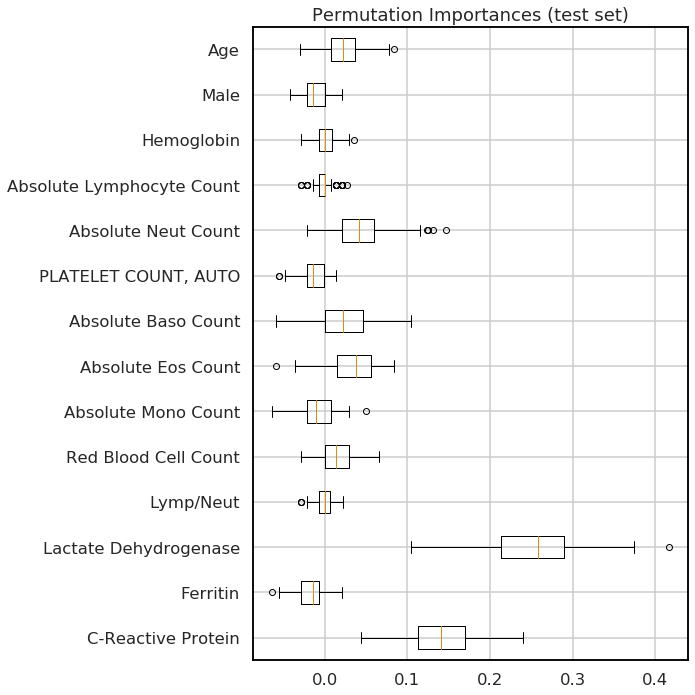

CPU times: user 17.9 s, sys: 841 ms, total: 18.8 s
Wall time: 2min 21s


In [20]:
%%time
viz_utils.plot_feature_importance(model,testData, n_repeats=100)